In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import json
import numpy as np
import itertools
from scipy.stats import gaussian_kde
from shapely.geometry import Point
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler

In [155]:
crime_gdf = gpd.read_file("./geojson/aichi-crime-2020.geojson")
print(len(crime_gdf))
crime_gdf.head()

45456


,id,crime,trick,police_station,police_box,city_code,prefecture,city,number,date,time,place,place_name,relevance,geometry
0,crime-00001,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,天塚町４丁目,2019-09-11,20,その他の住宅（３階建て以下共同住宅等）,"日本, 愛知県名古屋市西区天塚町4丁目",0.99,POINT (136.89271 35.20016)
1,crime-00002,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町２丁目,2019-08-05,18,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町2丁目",0.99,POINT (136.88114 35.20487)
2,crime-00003,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町３丁目,2019-05-23,08,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町3丁目",0.99,POINT (136.87985 35.20454)
3,crime-00004,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-10,17,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",0.99,POINT (136.89937 35.20313)
4,crime-00005,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-11,19,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",0.99,POINT (136.89937 35.20313)


In [3]:
# 信頼度0.8以上に限定
crime_gdf = crime_gdf[crime_gdf["relevance"] > 0.8]
print(len(crime_gdf))

39351


In [4]:
# 直交座標系に変換
crime_gdf = crime_gdf.to_crs(epsg=6675)

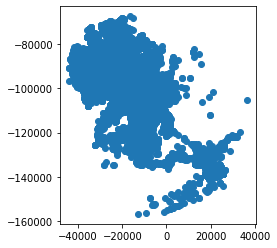

In [5]:
crime_gdf[crime_gdf["relevance"] > 0.8].plot()

In [163]:
# 犯罪種別（trick）でグループ化
crime_trick_gdf = crime_gdf.groupby("trick").count()
trick_list = crime_trick_gdf.index.values
print(trick_list)

['ひったくり' 'オートバイ盗' '自動販売機ねらい' '自動車盗' '自転車盗' '車上ねらい' '部品ねらい']


In [171]:
# 辞書型で複数のデータフレームを記録
crime_gdf_dict = {}
crime_gdf_dict["全体"] = crime_gdf

# 犯罪種別でデータフレームを生成
for trick in trick_list:
    value_gdf = crime_gdf[crime_gdf["trick"] == trick]
    crime_gdf_dict[trick] = value_gdf
    
for key in crime_gdf_dict:
    print(f"{key}: {len(crime_gdf_dict[key])}")

全体: 45456
ひったくり: 267
オートバイ盗: 1847
自動販売機ねらい: 1620
自動車盗: 2008
自転車盗: 28059
車上ねらい: 7070
部品ねらい: 4585


## サンプルデータでカーネル密度推定

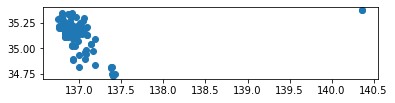

In [182]:
# サンプルを抽出(n=100)
n_sample = 100
sample_gdf = crime_gdf.sample(n_sample)
#display(sample_gdf)
sample_gdf.plot()

In [183]:
# 2次元配列に反感
coord_list= []
for g in sample_gdf["geometry"].values:
    coord_list.append(list(g.coords)[0])

coord_list = np.array(coord_list)
coord_list = np.transpose(coord_list)

print(coord_list.shape)

(2, 100)


In [184]:
# カーネル密度推定
bw_method = "scott"
#bw_method = "silverman"

kde = gaussian_kde(coord_list, bw_method=bw_method)

In [185]:
# 任意のデータを外挿
target_geometry = np.array([(0, 0), (1000, 1000), (-20000, -90000)])
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)
kde.evaluate(target_geometry)

(2, 3)


array([0., 0., 0.])

## 全データでカーネル密度推定

In [10]:
# 2次元配列に反感
coord_list= []
for g in crime_gdf["geometry"].values:
    coord_list.append(list(g.coords)[0])

coord_list = np.array(coord_list)
coord_list = np.transpose(coord_list)

print(coord_list.shape)

(2, 39351)


In [141]:
# カーネル密度推定
#bw_method = "scott"
bw_method = "silverman"
#bw_method = 1
#bw_method = 10

kde = gaussian_kde(coord_list, bw_method=bw_method)

In [142]:
# 任意のデータを外挿
target_geometry = np.array([(0, 0), (1000, 1000), (-20000, -90000)])
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)
kde.evaluate(target_geometry)

(2, 3)


array([0.0000000e+00, 0.0000000e+00, 1.9002447e-09])

## ヒートマップの生成

In [143]:
n_split = 40 # 1000x1000に分割
min_x = np.min(coord_list[0])
max_x = np.max(coord_list[0])
min_y = np.min(coord_list[1])
max_y = np.max(coord_list[1])
x_range = np.linspace(min_x, max_x, n_split)
y_range = np.linspace(min_y, max_y, n_split)

target_geometry = []
for x, y in itertools.product(x_range, y_range):
    target_geometry.append((x, y))

target_geometry = np.array(target_geometry)
target_geometry = np.transpose(target_geometry)
    
print(target_geometry.shape)

(2, 1600)


In [144]:
density_list = kde.evaluate(target_geometry)
print(len(density_list))
print(density_list)

1600
[1.49896127e-098 4.44567116e-089 3.55744061e-080 ... 5.74091690e-083
 6.55701226e-093 1.64697194e-103]


In [145]:
log_density_list = np.log10(density_list)
log_density_list = -1 * log_density_list
print(log_density_list)

mmscaler = MinMaxScaler(feature_range=(0, 1))
log_density_list = log_density_list.reshape(-1, 1)
mmscaler.fit(log_density_list)
alpha = mmscaler.transform(log_density_list)
alpha_list = alpha.reshape(1, -1)[0]
print(alpha_list)

[ 97.82420959  88.35206266  79.44886234 ...  82.24101874  92.183294
 102.7833138 ]
[0.94748229 0.84717074 0.75288443 ... 0.78245381 0.8877441  1.        ]


In [146]:
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)

(1600, 2)


In [147]:
# GeoJSONに変換
geojson = {
    "type": "FeatureCollection",
    "features": []
}

# ポリゴンの1辺の距離
length_x = np.abs(x_range[1] - x_range[0])
length_y = np.abs(y_range[1] - y_range[0])
radius_x = length_x / 2
radius_y = length_y / 2
print(f"length_x={length_x} length_y={length_y}")

features = []
for (x,y),density,alpha in zip(target_geometry, density_list, alpha_list):
    #print(f"{x} {y} {density}")

    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[[x-radius_x,  y-radius_y],[x+radius_x, y-radius_y],[x+radius_x, y+radius_y],[x-radius_x,  y+radius_y],[x-radius_x,  y-radius_y]]],
        },
        "properties": {
            "density": density,
            "alpha": alpha
        }
    }
    
    features.append(feature)
    
geojson["features"] = features
print(geojson["features"][0])

length_x=2068.294327900243 length_y=2296.2474244152254
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-45094.12372657351, -158025.08585355704], [-43025.829398673275, -158025.08585355704], [-43025.829398673275, -155728.8384291418], [-45094.12372657351, -155728.8384291418], [-45094.12372657351, -158025.08585355704]]]}, 'properties': {'density': 1.4989612720206684e-98, 'alpha': 0.947482293409438}}


In [148]:
# GeoJSONファイルを書込
with open("./geojson/crime-density-2020.geojson", "w") as f:
    json.dump(geojson, f, ensure_ascii=False)

In [149]:
density_gdf = gpd.read_file("./geojson/crime-density-2020.geojson")
density_gdf = density_gdf.set_crs(epsg=6675, allow_override=True)
print(len(density_gdf))
display(density_gdf)

1600


,density,alpha,geometry
0,1.498961e-98,0.947482,"POLYGON ((-45094.124 -158025.086, -43025.829 -..."
1,4.445671e-89,0.847171,"POLYGON ((-45094.124 -155728.838, -43025.829 -..."
2,3.557441e-80,0.752884,"POLYGON ((-45094.124 -153432.591, -43025.829 -..."
3,6.263030e-72,0.665562,"POLYGON ((-45094.124 -151136.344, -43025.829 -..."
4,2.424863e-64,0.585205,"POLYGON ((-45094.124 -148840.096, -43025.829 -..."
...,...,...,...
1595,4.680564e-65,0.592770,"POLYGON ((35569.355 -77656.426, 37637.649 -776..."
1596,1.105381e-73,0.684129,"POLYGON ((35569.355 -75360.179, 37637.649 -753..."
1597,5.740917e-83,0.782454,"POLYGON ((35569.355 -73063.931, 37637.649 -730..."
1598,6.557012e-93,0.887744,"POLYGON ((35569.355 -70767.684, 37637.649 -707..."


In [150]:
# 現在のEPSGコード
density_gdf.crs

<Projected CRS: EPSG:6675>
Name: JGD2011 / Japan Plane Rectangular CS VII
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Japan - onshore - Honshu between approximately 136°15'E and 137°45'E - Ishikawa-ken; Toyama-ken; Gifu-ken; Aichi-ken.
- bounds: (136.22, 34.51, 137.84, 37.58)
Coordinate Operation:
- name: Japan Plane Rectangular CS zone VII
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [151]:
# 緯度軽度に変換
density_gdf = density_gdf.to_crs(epsg=4326)
display(density_gdf)

,density,alpha,geometry
0,1.498961e-98,0.947482,"POLYGON ((136.67517 34.57452, 136.69772 34.574..."
1,4.445671e-89,0.847171,"POLYGON ((136.67505 34.59522, 136.69760 34.595..."
2,3.557441e-80,0.752884,"POLYGON ((136.67493 34.61593, 136.69748 34.616..."
3,6.263030e-72,0.665562,"POLYGON ((136.67481 34.63663, 136.69737 34.636..."
4,2.424863e-64,0.585205,"POLYGON ((136.67469 34.65733, 136.69725 34.657..."
...,...,...,...
1595,4.680564e-65,0.592770,"POLYGON ((137.55777 35.29939, 137.58051 35.299..."
1596,1.105381e-73,0.684129,"POLYGON ((137.55787 35.32009, 137.58062 35.320..."
1597,5.740917e-83,0.782454,"POLYGON ((137.55797 35.34079, 137.58073 35.340..."
1598,6.557012e-93,0.887744,"POLYGON ((137.55807 35.36149, 137.58083 35.361..."


In [152]:
# ランクを生成
rank_series = density_gdf["alpha"].rank()
density_gdf["rank"] = rank_series
display(density_gdf)

,density,alpha,geometry,rank
0,1.498961e-98,0.947482,"POLYGON ((136.67517 34.57452, 136.69772 34.574...",1599.0
1,4.445671e-89,0.847171,"POLYGON ((136.67505 34.59522, 136.69760 34.595...",1595.0
2,3.557441e-80,0.752884,"POLYGON ((136.67493 34.61593, 136.69748 34.616...",1590.0
3,6.263030e-72,0.665562,"POLYGON ((136.67481 34.63663, 136.69737 34.636...",1583.0
4,2.424863e-64,0.585205,"POLYGON ((136.67469 34.65733, 136.69725 34.657...",1574.0
...,...,...,...,...
1595,4.680564e-65,0.592770,"POLYGON ((137.55777 35.29939, 137.58051 35.299...",1576.0
1596,1.105381e-73,0.684129,"POLYGON ((137.55787 35.32009, 137.58062 35.320...",1585.0
1597,5.740917e-83,0.782454,"POLYGON ((137.55797 35.34079, 137.58073 35.340...",1592.0
1598,6.557012e-93,0.887744,"POLYGON ((137.55807 35.36149, 137.58083 35.361...",1597.0


In [153]:
# GeoJSON形式で保存
path = f"./geojson/crime-density-band-{bw_method}.js"
density_gdf.to_file(path, driver='GeoJSON')